# Plan Enumeration

Copyright Immanuel Haffner, Jens Dittrich  [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

## Set-Up

In [1]:
from dataclasses import dataclass
import graphviz as gv
import itertools
import math
import random as rnd
import typing

## Define a Join Graph Data Structure

A join graph is a collection of named relations and joins of these relations.  The join graph implements certain sanity
checks:  (1) No two relations must have the same name.  (2) The selectivity of a join must be in the range 0 to 1
(inclusive).  (3)  The relations that a join refers to must be present in the join graph.

This class is meant to be used as a single handle to a potentially complex join graph structure.

In [2]:
class JoinGraph:
    @dataclass(eq=True, frozen=True)
    class Relation:
        name: str
        size: int

    @dataclass(eq=True, frozen=True)
    class Join:
        selectivity: float
        relation_names: typing.Tuple

    def __init__(self):
        self.named_relations = dict()
        self.joins = set()

    def add_relation(self, name, size):
        if name in self.named_relations:
            raise ValueError(f'Name "{name}" already taken')
        self.named_relations[name] = JoinGraph.Relation(name, size)

    def add_join(self, selectivity, *relation_names):
        # Make sure, all relations are present
        for tn in relation_names:
            if not tn in self.named_relations:
                raise ValueError(f'No relation with name "{tn}"')
        if not (0 <= selectivity <= 1):
            raise ValueError(f'Illegal selectivity of {selectivity}; must be in the range 0 to 1.')
        self.joins.add(JoinGraph.Join(selectivity, relation_names))

### Let us define a concrete scenario.

In [3]:
# Create a new join graph.
the_join_graph = JoinGraph()

# Add relations to the join graph.
the_join_graph.add_relation('A', 4000)
the_join_graph.add_relation('B', 1000)
the_join_graph.add_relation('C', 2000)
the_join_graph.add_relation('D', 3000)

# Add joins to the join graph.
the_join_graph.add_join(0.025, 'A', 'B')
the_join_graph.add_join(0.003, 'A', 'C')
the_join_graph.add_join(0.045, 'B', 'C')
the_join_graph.add_join(0.370, 'B', 'D')
the_join_graph.add_join(0.012, 'C', 'D')

### Define a function to draw the join graph with the graphviz tool.

In [4]:
def draw_join_graph(graph):
    G = gv.Graph(name='join_graph', comment='The Join Graph')

    # Find the minimum and maximum join selectivities in the join graph
    sel_min = sel_max = 0
    for J in graph.joins:
        sel_min = min(sel_min, J.selectivity)
        sel_max = max(sel_max, J.selectivity)

    # Add the Relations as vertices.
    for T in graph.named_relations.values():
        G.node(T.name, f'<<B>{T.name}</B><SUB><FONT POINT-SIZE="10">|·|={T.size:,}</FONT></SUB>>')

    # Add the joins as edges with their selectivity as label.
    for J in graph.joins:
        vertices = J.relation_names
        for i in range(1, len(vertices)):
            x = 1 - (J.selectivity - sel_min) / (sel_max - sel_min)
            penwidth = 3.5 * x**5 + 0.4 # compute the stroke width proportionally to the selectivity
            G.attr('edge', penwidth=str(penwidth))
            G.edge(vertices[i-1], vertices[i], label=f'{J.selectivity:f}')

    return gv.Source(G)

### Show the join graph for our scenario.

**NOTE:** The join graph can be extended where there is no join between two relations.  In that case, the relations can
be combined only with a Cartesian product, which is equivalent to a join with a selectivity of 1.

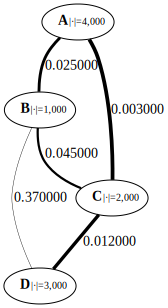

In [5]:
draw_join_graph(the_join_graph)

## Computing the Cost of a Query Plan

A query plan can be visualized as a tree structure.  The leaves of the tree are the input relations and the inner nodes
are joins.  The root of the tree is the final join which yields the result.  Inner nodes, except for the root node, are
intermediate results.

We will restrict ourselves to query plans in the shape of left-deep trees.  The important property of these query plans
is that, at any time, there is at most one intermediate result.  Since we restrict ourselves to left-deep trees, and
hence the shape of tree is fixed, we can represent a query plan simply as a sequence of relation names.  Below we will
visualize such a left-deep query plan.

### Randomly select a query plan.

This function selects a random query plan and completely ignores the presence of join predicates.

In [6]:
def select_query_plan_rnd(graph):
    query_plan = [T.name for T in graph.named_relations.values()]
    rnd.shuffle(query_plan)
    return query_plan

Get a randomly chosen query plan.

In [7]:
rnd.seed(42) # use a fixed seed for reproducibility
rnd_query_plan = select_query_plan_rnd(the_join_graph)
print(rnd_query_plan)

['C', 'B', 'D', 'A']


### Define a function to draw a left-deep query plan given a sequence of relations.

In [8]:
def draw_query_plan(plan):
    G = gv.Graph(name='query_plan', comment='The Query Plan')
    G.graph_attr['rankdir'] = 'BT'

    # Add the Relations as leaves.
    for tbl in plan:
        G.node(tbl, f'<<B>{tbl}</B>>')

    # Add the joins as inner nodes.
    left = plan[0]
    for i in range(1, len(plan)):
        right = plan[i]
        G.node(str(i), '⋈')
        G.edge(left, str(i))
        G.edge(right, str(i))
        left = str(i)

    return gv.Source(G)

Draw the random query plan

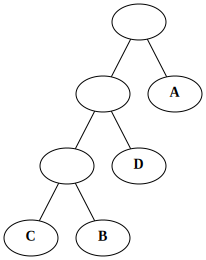

In [9]:
draw_query_plan(rnd_query_plan)

### Defining a Cost Model

First we need to define a cost function to estimate the cost of a join.  We define a cost function that estimates the
cost of a join as the sum of the sizes of the two input relations, called `size_of_inputs`.  (This is similar the the
cost model of the running time of a hash join, given $c_1$ and $c_2$ are 1.)

In [10]:
class CostFunctions:
    # The cost of a join is equal to the sum of the size of all input relations.
    def size_of_inputs(size_left, size_right, selectivity):
        return size_left + size_right

Next we define a function to compute the cost of a query plan given the plan, the join graph, and a cost function.

**NOTE:** The cost function (of a single join) is a parameter of the `compute_cost` function.  By using different cost
functions we are able to compute the cost of a query plan for different cost models.  This allows us to compute the cost
of a plan with respective to, e.g., running time, memory consumption, power consumption, etc.

In [11]:
def compute_cost(plan, graph, cost_fn):
    # Start with the first relation.
    first = plan[0]
    joined = set([first])
    size_left = graph.named_relations[first].size
    cost = 0
    #print(f'Start with relation {first} of size {size_left:,}')

    # Join each relation one after the other.
    for i in range (1, len(plan)):
        right = plan[i]

        # Combine all join predicates.  If no join predicate is applicable, the selectivity remains 1 and the join
        # degenerates to the Cartesian product.
        selectivity = 1
        for J in graph.joins:
            if right in J.relation_names and len(joined.intersection(J.relation_names)) != 0:
                selectivity *= J.selectivity

        # TODO: What to do with the print statements?
        size_right = graph.named_relations[right].size
        #print(f'Join {joined} of size {size_left} and {right} of size {size_right} with combined selectivity {selectivity:f}.')
        # Add the cost of this join to the total cost.
        cost += cost_fn(size_left, size_right, selectivity)
        # Compute the size of the new intermediate result.
        size_left = round(selectivity * size_left * size_right)
        #print(f'  --> Cost = {cost:,}, Size = {size_left:,}')
        joined.add(right)

    return cost

Let us now compute the cost of our randomly chosen plan under the cost function `size_of_inputs`.

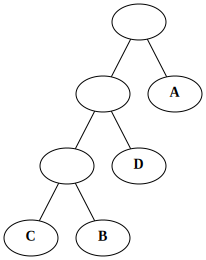

The estimated total cost of the query plan is 1,298,800.


In [12]:
display(draw_query_plan(rnd_query_plan)) # repeated here to be on screen
cost = compute_cost(rnd_query_plan, the_join_graph, CostFunctions.size_of_inputs)
print(f'The estimated total cost of the query plan is {cost:,}.')

## Demonstration

### Four randomly chosen query plans and their estimated costs according to the `size_of_inputs` cost function.

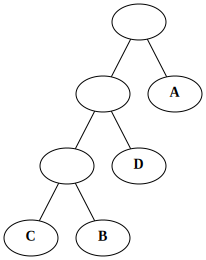

Estimated cost: 1,298,800




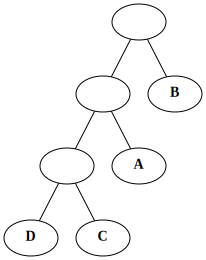

Estimated cost: 946,000




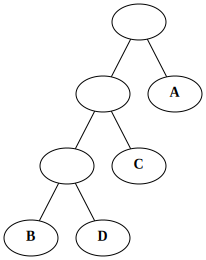

Estimated cost: 2,318,800




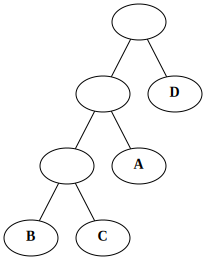

Estimated cost: 127,000




In [13]:
rnd.seed(42) # fixed seed for reproducible results
for i in range(0, 4):
    plan = select_query_plan_rnd(the_join_graph)
    display(draw_query_plan(plan))
    cost = compute_cost(plan, the_join_graph, CostFunctions.size_of_inputs)
    print(f'Estimated cost: {cost:,}\n\n')

#### Conclusion

We can observe that, although the shape of the query plan is fixed, the order in which the relations are joined already
has a big impact on the estimated total cost of the plan.  The best plan in this demonstration with a total cost of
`127,000` is already 7.5 times better than the second best plan with total cost `946,000` and 18 times better than the
worst plan we randomly chose.

This demonstration empirically emphasizes the need for an efficient solution to finding the cheapest plan w.r.t. the
cost model.

## Finding the Cheapest Plan by Exhaustive Plan Enumeration

To find the cheapest plan for a join graph and a cost model, we can exhaustively list all possible plans and compute
their estimated costs.  The plan with the smallest cost will be selected.

**NOTE:** This solution does not fulfill the criteria of an *efficient* solution and is meant to serve as an
introduction with educational purpose.

In [14]:
def find_cheapest_plan_exhaustive(join_graph, cost_fn):
    # Extract the relation names
    relations = [R.name for R in join_graph.named_relations.values()]

    least_cost = math.inf
    cheapest_plan = None

    # Consider all possible permutations (of which there are $n!$).
    for perm in itertools.permutations(relations):
        cost = compute_cost(perm, join_graph, cost_fn)
        if cost < least_cost:
            least_cost = cost
            cheapest_plan = perm

    return cheapest_plan

Find the cheapest plan for our join graph.

CPU times: user 303 µs, sys: 6 µs, total: 309 µs
Wall time: 314 µs


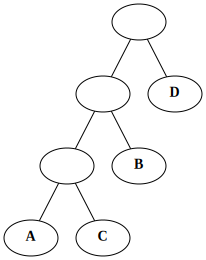

The cheapest plan is ('A', 'C', 'B', 'D') with cost 61,000.


In [15]:
%time plan = find_cheapest_plan_exhaustive(the_join_graph, CostFunctions.size_of_inputs)
display(draw_query_plan(plan))
cost = compute_cost(plan, the_join_graph, CostFunctions.size_of_inputs)
print(f'The cheapest plan is {plan} with cost {cost:,}.')

### A more complex join graph.

This is a join graph for the IMDb data set, extended with the cinemas relation where movies are shown.

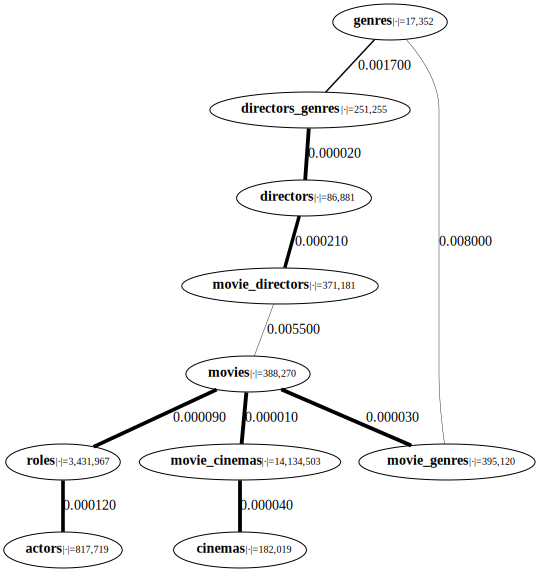

In [16]:
imdb_graph = JoinGraph()

imdb_graph.add_relation('genres', 17_352)
imdb_graph.add_relation('directors_genres', 251_255)
imdb_graph.add_relation('directors', 86_881)
imdb_graph.add_relation('movie_directors', 371_181)
imdb_graph.add_relation('movies', 388_270)
imdb_graph.add_relation('movie_genres', 395_120)
imdb_graph.add_relation('roles', 3_431_967)
imdb_graph.add_relation('actors', 817_719)
imdb_graph.add_relation('movie_cinemas', 14_134_503)
imdb_graph.add_relation('cinemas', 182_019)

imdb_graph.add_join(0.00170,  'genres', 'directors_genres')
imdb_graph.add_join(0.00002, 'directors_genres', 'directors')
imdb_graph.add_join(0.00021, 'directors', 'movie_directors')
imdb_graph.add_join(0.00550, 'movie_directors', 'movies')
imdb_graph.add_join(0.00003, 'movies', 'movie_genres')
imdb_graph.add_join(0.00800, 'movie_genres', 'genres')
imdb_graph.add_join(0.00009, 'movies', 'roles')
imdb_graph.add_join(0.00012, 'roles', 'actors')
imdb_graph.add_join(0.00001, 'movies', 'movie_cinemas')
imdb_graph.add_join(0.00004, 'movie_cinemas', 'cinemas')

draw_join_graph(imdb_graph)

#### Compute the optimal plan using exhaustive plan enumeration.

This will take a while.  (On my notebook this took roughly one minute.)  The time for finding the optimal plan is
reported using the `%time` magic.

CPU times: user 1min 21s, sys: 95 ms, total: 1min 21s
Wall time: 1min 21s


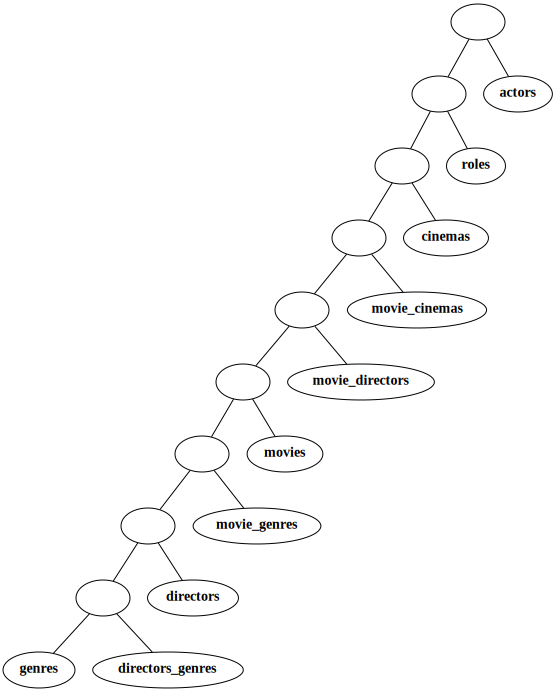

The cheapest plan is ('genres', 'directors_genres', 'directors', 'movie_genres', 'movies', 'movie_directors', 'movie_cinemas', 'cinemas', 'roles', 'actors') with cost 64,856,523,035,553,260.


In [17]:
%time plan = find_cheapest_plan_exhaustive(imdb_graph, CostFunctions.size_of_inputs)
display(draw_query_plan(plan))
cost = compute_cost(plan, imdb_graph, CostFunctions.size_of_inputs)
print(f'The cheapest plan is {plan} with cost {cost:,}.')

Although this scenario is artificially constructed, join graphs with similar complexity are commonly found in business
applications and are not a synthetic problem.  Waiting about one minute just to find the plan before we even start
evaluating the query is definitely intolerable.  We must improve the query planning algorithm.

## Pruning the Search Space of Plan Enumeration

Usually, by defining foreign keys in the schema we already define which relations are meant to be joined.  By explicitly
stating join predicates in the query, we also give advice which and how relations should be joined.

For example, consider the relation `directors`.  As shown in the join graph, this relation can be joined with the
relations `directors_genres` and `movie_directors`.  This means that this join produces presumably less tuples than a
Cartesian product, assuming that the selectivity of the join predicate is less than 1.  On the contrary, there is no
join predicate to join the `directors` and the `movies` relation; this is visible in the join graph as there is no edge
between the two relations.  This means, to combine these two relations directly, a Cartesian product would be necessary,
resulting in a quadratic explosion of intermediate result tuples.

### Exercise for assignment sheet 6

Improve over exhaustive plan enumeration by considering only plans without Cartesian products.  You may assume that the
join graph is always a [connected graph](https://en.wikipedia.org/wiki/Connectivity_(graph_theory)).

In [18]:
def find_cheapest_plan_with_pruning(join_graph, cost_fn):
    # TODO: Exercise for assignment sheet 6
    pass